In [2]:
!unzip "/content/drive/MyDrive/PIXSELECT/fer2013.zip" -d "/content/drive/MyDrive/PIXSELECT/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_55055565.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_55099068.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_55505039.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_55599585.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_55759553.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_55936523.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_56425128.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_56538669.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_56783023.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateTest_56810617.jpg  
  inflating: /content/drive/MyDrive/PIXSELECT/data/test/fear/PrivateT

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#Train
import tensorflow as tf
import keras

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
train_dir = "/content/drive/MyDrive/PIXSELECT/data/train/" #passing the path with training images
test_dir = "/content/drive/MyDrive/PIXSELECT/data/test/"   #passing the path with testing images

In [7]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count, "\n")
print(test_count)

       angry  fear  happy  neutral   sad
train   3995  4097   7215     4965  4830 

      angry  fear  happy  neutral   sad
test    958  1024   1774     1233  1247


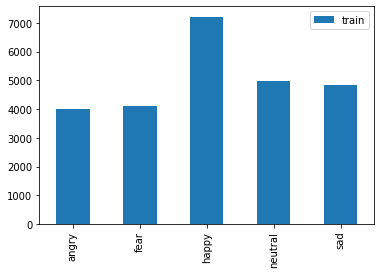

In [8]:
train_count.transpose().plot(kind='bar')

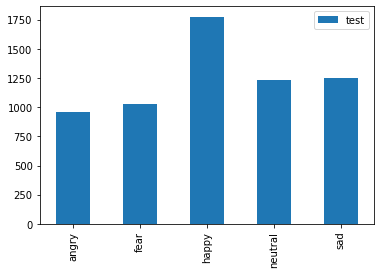

In [9]:
test_count.transpose().plot(kind='bar')

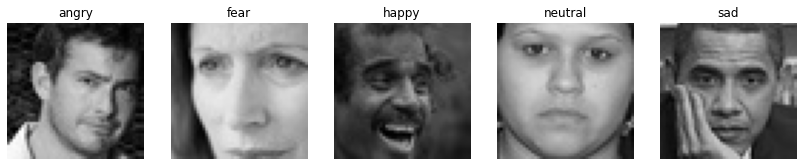

In [10]:
plt.figure(figsize = (20, 20))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

###**Data Augmentation**

In [11]:
train_datagen = ImageDataGenerator(
                                         rotation_range = 30,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.2,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         fill_mode='nearest'
                                         #zoom_range = 0.2,
                                         #validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255
                                         #validation_split = 0.2
                                       )

In [12]:
img_size = 48

In [13]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical"
                                                             )

Found 25102 images belonging to 5 classes.
Found 6236 images belonging to 5 classes.


###**MODEL**

In [14]:
model = tf.keras.models.Sequential()   

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu')) 
model.add(Dense(5, activation='softmax'))

    #Compliling the model
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [16]:
batch_size=64
epochs=100

In [17]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-10),
              EarlyStopping(monitor='val_loss', verbose=1, patience=15)]

In [18]:
history = model.fit(           
                        x=train_generator,
                        epochs = epochs,
                        validation_data = validation_generator,
                        callbacks=callbacks
                    )

Epoch 1/100
393/393 [==============================] - 83s 173ms/step - loss: 16.2225 - accuracy: 0.2368 - val_loss: 15.1762 - val_accuracy: 0.2726 - lr: 1.0000e-04
Epoch 2/100
393/393 [==============================] - 63s 159ms/step - loss: 14.2663 - accuracy: 0.2564 - val_loss: 13.2038 - val_accuracy: 0.2757 - lr: 1.0000e-04
Epoch 3/100
393/393 [==============================] - 59s 151ms/step - loss: 12.1985 - accuracy: 0.2676 - val_loss: 11.1235 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 4/100
393/393 [==============================] - 59s 151ms/step - loss: 10.1432 - accuracy: 0.2754 - val_loss: 9.1347 - val_accuracy: 0.2883 - lr: 1.0000e-04
Epoch 5/100
393/393 [==============================] - 58s 147ms/step - loss: 8.2519 - accuracy: 0.2874 - val_loss: 7.3969 - val_accuracy: 0.2850 - lr: 1.0000e-04
Epoch 6/100
393/393 [==============================] - 58s 147ms/step - loss: 6.6236 - accuracy: 0.2940 - val_loss: 5.9364 - val_accuracy: 0.2893 - lr: 1.0000e-04
Epoch 7/100
393

###**EVALUATION**

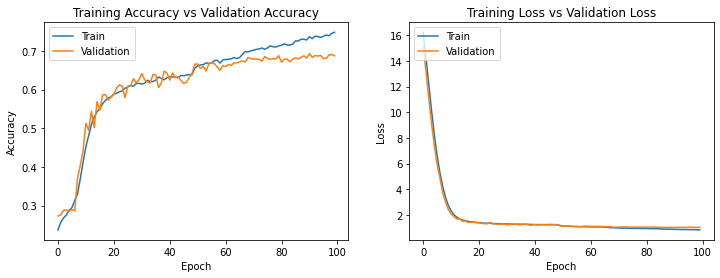

In [19]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.savefig('training.jpg')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

98/98 [==============================] - 8s 84ms/step - loss: 1.0361 - accuracy: 0.6873
final train accuracy = 79.13 , validation accuracy = 68.73


###**CONFUSION MATRIX**

In [21]:
predictions = model.predict(validation_generator)

In [22]:
label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad'}

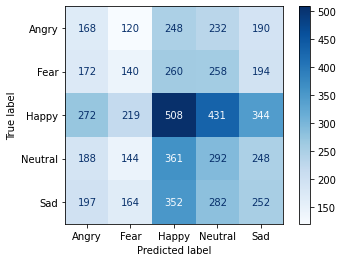

In [23]:

c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
#print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=label_dict.values())
cm_display.plot(cmap=plt.cm.Blues,xticks_rotation="horizontal")
plt.show()

###**TESTING**

(48, 48)


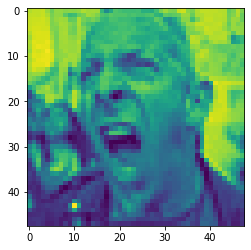

In [31]:
img = image.load_img("/content/drive/MyDrive/PIXSELECT/data/test/angry/PrivateTest_12008383.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [32]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[1.0, 0.0, 0.0, 2.284316e-12, 5.9014095e-32]


In [33]:
img_index = result.index(max(result))
print(label_dict[img_index])

Angry


###**SAVE**

In [ ]:
#model.save('PIXSELECT-CNN.h5')